In [3]:
from qiskit import QuantumCircuit, transpile
from qiskit.visualization import plot_histogram
from qiskit.quantum_info import Statevector
import numpy as np
from scipy.io.wavfile import read
import matplotlib.pyplot as plt
from qiskit.circuit.library import QFT
from qiskit_aer import AerSimulator, Aer, aer_simulator
from scipy.io.wavfile import read, write


In [42]:
n_qubits = 10

In [43]:
def load_and_normalize_audio(filename):
    """Load audio file in blocks of 2^n_qubits samples"""
    sample_rate, audio = read(filename)

    # Convert to mono if stereo
    if len(audio.shape) > 1:
        audio = audio[:, 0]
    
    target_samples = 2**n_qubits
    audio = audio[:target_samples]  

    norm_factor = np.linalg.norm(audio)
    normalized_audio = audio / norm_factor
    
    return sample_rate, normalized_audio, norm_factor, n_qubits

def prepare_quantum_state(normalized_audio):
    """Prepare a quantum state from normalized audio data."""
    qc = QuantumCircuit(n_qubits)

    # Initialize the quantum state with the normalized audio data
    qc.initialize(normalized_audio, range(n_qubits))

    return qc

In [44]:
def denoise_oracle(statevector, threshold=0.05):

    probabilities = np.abs(statevector.data) ** 2

    for i in range (0,2**n_qubits):
        if probabilities[i] < threshold:
            statevector.data[i] = 0
        else:
            print(i)
    
    norm_factor2 = np.linalg.norm(statevector.data)
    normalized_denoise = statevector.data
    if norm_factor2 > 1e-10:
        normalized_denoise = statevector.data/norm_factor2

    denoised_state = prepare_quantum_state(normalized_denoise)
    

    return denoised_state

In [45]:
audio_file = "noisy_audio.wav"

# Load and normalize audio data
sample_rate, normalized_audio, norm_factor, n_qubits = load_and_normalize_audio(audio_file)

qc = prepare_quantum_state(normalized_audio)

qc.append(QFT(n_qubits, do_swaps=True), range(n_qubits))


# Get state after QFT
state = Statevector(qc)  

# Apply oracle to denoise the signal
qc = qc.compose((denoise_oracle(state)))

# Inverse QFT to return to time domain
qc = qc.compose(QFT(n_qubits, do_swaps=True, inverse=True), range(n_qubits))

# "Measure" the statevector
backend = Aer.get_backend('statevector_simulator')
qc = transpile(qc, backend)

state = Statevector(qc)  

retrieved_audio = (state.data.real)



10
1014


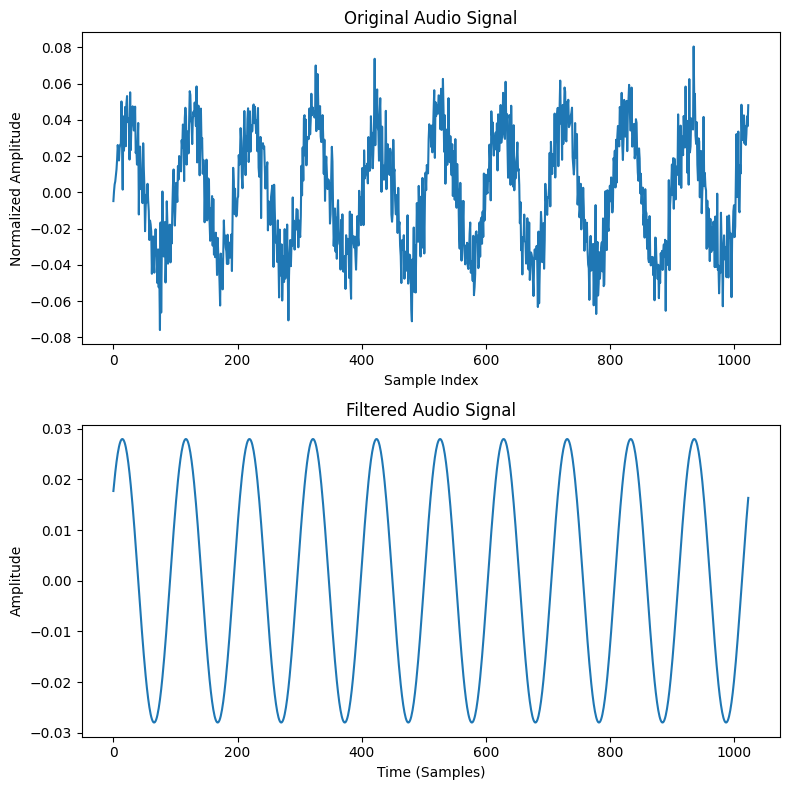

In [46]:


plt.figure(figsize=(8,8))

plt.subplot(2, 1, 1)
plt.plot(range(2**n_qubits), normalized_audio)
plt.title("Original Audio Signal")
plt.xlabel("Sample Index")
plt.ylabel("Normalized Amplitude")

plt.subplot(2, 1, 2)
plt.plot(range(2**n_qubits), retrieved_audio)
plt.title("Filtered Audio Signal")
plt.xlabel("Time (Samples)")
plt.ylabel("Amplitude")

plt.tight_layout()
plt.show()

In [34]:
filtered_audio = np.int16(retrieved_audio) 

output_filename = "quantum_filtered.wav"
write(output_filename, sample_rate, filtered_audio)

In [37]:
def load_and_normalize_audio(filename, n_qubits=10):
    """Load audio file in blocks of 2^n_qubits samples"""
    sample_rate, audio = read(filename)

    # Convert to mono if stereo
    if len(audio.shape) > 1:
        audio = audio[:, 0]
    
    target_samples = 2**n_qubits
    num_blocks = len(audio) // target_samples
    audio_blocks = [audio[i*target_samples:(i+1)*target_samples] for i in range(num_blocks)]
    
    return sample_rate, audio_blocks, n_qubits
import numpy as np
from scipy.io.wavfile import read
from qiskit import QuantumCircuit, transpile
from qiskit.circuit.library import QFT
from qiskit.quantum_info import Statevector
from qiskit_aer import Aer

def load_and_normalize_audio(filename, n_qubits=10):
    """Load audio file in blocks of 2^n_qubits samples"""
    sample_rate, audio = read(filename)

    # Convert to mono if stereo
    if len(audio.shape) > 1:
        audio = audio[:, 0]
    
    target_samples = 2**n_qubits
    num_blocks = len(audio) // target_samples
    audio_blocks = [audio[i*target_samples:(i+1)*target_samples] for i in range(num_blocks)]
    
    return sample_rate, audio_blocks, n_qubits

def process_block(audio_block, n_qubits):
    """Process a single audio block through QFT denoising"""
    # Normalize
    norm_factor = np.linalg.norm(audio_block)
    normalized_audio = audio_block / (norm_factor + 1e-10)  # Avoid division by zero
    
    # Prepare quantum state
    qc = QuantumCircuit(n_qubits)
    qc.initialize(normalized_audio, range(n_qubits))
    
    # Apply QFT
    qc.append(QFT(n_qubits, do_swaps=True), range(n_qubits))
    
    # Get state after QFT
    state = Statevector.from_instruction(qc)
    
    # Apply oracle to denoise
    denoised_state = denoise_oracle(state)
    
    # Create new circuit with denoised state
    denoised_qc = QuantumCircuit(n_qubits)
    denoised_qc.initialize(denoised_state, range(n_qubits))  # Use Statevector directly
    
    # Combine with original circuit
    qc = qc.compose(denoised_qc)
    
    # Inverse QFT
    qc.append(QFT(n_qubits, do_swaps=True, inverse=True), range(n_qubits))
    
    # Get final statevector
    final_state = Statevector.from_instruction(qc)
    retrieved_audio = np.real(final_state.data) * norm_factor  # Restore original scale
    
    return retrieved_audio

# Main processing
audio_file = "noisy_audio.wav"
n_qubits = 10  # 1024 samples per block
sample_rate, audio_blocks, _ = load_and_normalize_audio(audio_file, n_qubits)

processed_blocks = []
for block in audio_blocks:
    processed_block = process_block(block, n_qubits)
    processed_blocks.append(processed_block)

# Combine all processed blocks
full_processed_audio = np.concatenate(processed_blocks)

# Plot results
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.plot(np.concatenate(audio_blocks), label='Original')
plt.plot(full_processed_audio, label='Processed', alpha=0.7)
plt.legend()
plt.title("Quantum Audio Denoising (1024-sample blocks)")
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.show()
def process_block(audio_block, n_qubits):
    """Process a single audio block through QFT denoising"""
    # Normalize
    norm_factor = np.linalg.norm(audio_block)
    normalized_audio = audio_block / norm_factor
    
    # Prepare quantum state
    qc = QuantumCircuit(n_qubits)
    qc.initialize(normalized_audio, range(n_qubits))
    
    # Apply QFT
    qc.append(QFT(n_qubits, do_swaps=True), range(n_qubits))
    
    # Get state after QFT
    state = Statevector(qc)  
    
    # Apply oracle to denoise
    denoised_state = denoise_oracle(state)
    
    # Convert back to operations
    denoised_qc = QuantumCircuit(n_qubits)
    denoised_qc.initialize(denoised_state.data, range(n_qubits))
    qc = qc.compose(denoised_qc)
    
    # Inverse QFT
    qc.append(QFT(n_qubits, do_swaps=True, inverse=True), range(n_qubits))
    
    # Get final statevector
    final_state = Statevector(qc)  
    retrieved_audio = final_state.data.real * norm_factor  # Restore original scale
    
    return retrieved_audio

# Main processing
audio_file = "noisy_audio.wav"
n_qubits = 10  # 1024 samples per block
sample_rate, audio_blocks, _ = load_and_normalize_audio(audio_file, n_qubits)

processed_blocks = []
for block in audio_blocks:
    processed_blocks.append(process_block(block, n_qubits))

# Combine all processed blocks
full_processed_audio = np.concatenate(processed_blocks)

# Plot results
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.plot(np.concatenate(audio_blocks), label='Original')
plt.plot(full_processed_audio, label='Processed', alpha=0.7)
plt.legend()
plt.title("Quantum Audio Denoising (1024-sample blocks)")
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.show()

10
1014


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (1, 3) + inhomogeneous part.

In [16]:


def load_audio_in_chunks(filename, n_qubits):
    """Load and normalize audio file in blocks of 2^n_qubits samples."""
    sample_rate, audio = read(filename)

    # Convert to mono if stereo
    if len(audio.shape) > 1:
        audio = audio[:, 0]
    audio=audio[:2048]
    chunk_size = 2**n_qubits
    num_chunks = len(audio) // chunk_size
    chunks = np.array_split(audio[:num_chunks * chunk_size], num_chunks)
    
    norm_factors = [np.linalg.norm(chunk) for chunk in chunks]
    normalized_chunks = [chunk / nf if nf > 1e-10 else chunk for chunk, nf in zip(chunks, norm_factors)]

    return sample_rate, audio, normalized_chunks, norm_factors, n_qubits

def prepare_quantum_state(normalized_audio, n_qubits):
    """Prepare a quantum state from normalized audio data."""
    qc = QuantumCircuit(n_qubits)
    qc.initialize(normalized_audio, range(n_qubits))
    return qc

def denoise_oracle(statevector, n_qubits, threshold=0.05):

    probabilities = np.abs(statevector.data) ** 2

    for i in range (0,2**n_qubits):
        if probabilities[i] < threshold:
            statevector.data[i] = 0
        else:
            print(i)
    
    norm_factor2 = np.linalg.norm(statevector.data)
    if norm_factor2 > 1e-10:
        normalized_denoised = statevector.data / norm_factor2
    else:
        normalized_denoised = statevector.data

    denoised_state = prepare_quantum_state(normalized_denoised,n_qubits)
    

    return denoised_state

def process_audio_chunk(normalized_audio, n_qubits):
    """Quantum process an audio chunk."""
    qc = prepare_quantum_state(normalized_audio, n_qubits)
    
    # Apply QFT
    qc.append(QFT(n_qubits, do_swaps=True), range(n_qubits))

    # Get statevector
    backend = Aer.get_backend('statevector_simulator')
    qc = transpile(qc, backend)
    state = Statevector(qc)

    # Apply denoising
    qc = denoise_oracle(state, n_qubits)

    # Apply inverse QFT
    qc.append(QFT(n_qubits, do_swaps=True, inverse=True), range(n_qubits))

    # Get final statevector
    qc = transpile(qc, backend)
    state = Statevector(qc)

    return state.data.real  # Convert back to real audio signal

# Main Processing Loop
audio_file = "noisy_audio.wav"
n_qubits = 10  # Adjust based on available quantum resources

sample_rate, og_audio, normalized_chunks, norm_factors, n_qubits = load_audio_in_chunks(audio_file, n_qubits)

processed_chunks = [process_audio_chunk(chunk, n_qubits) * nf for chunk, nf in zip(normalized_chunks, norm_factors)]

# Reconstruct full audio
final_audio = np.concatenate(processed_chunks)

# Save the processed audio
write("denoised_audio.wav", sample_rate, final_audio.astype(np.int16))


320
447
320
447


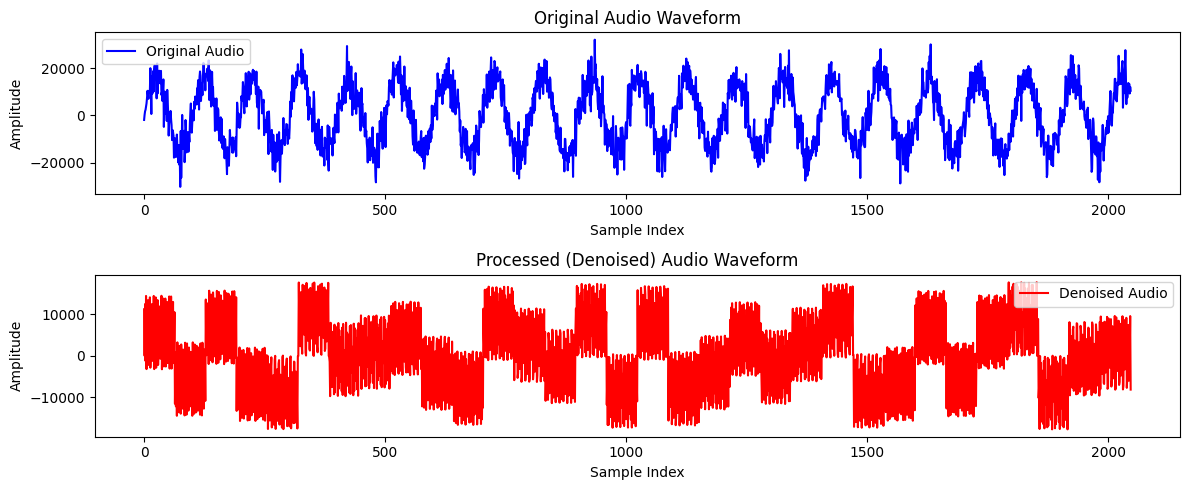

In [17]:
plt.figure(figsize=(12, 5))

# Plot original audio
plt.subplot(2, 1, 1)
plt.plot(og_audio, color='blue', label="Original Audio")
plt.title("Original Audio Waveform")
plt.xlabel("Sample Index")
plt.ylabel("Amplitude")
plt.legend()

# Plot processed audio
plt.subplot(2, 1, 2)
plt.plot(final_audio, color='red', label="Denoised Audio")
plt.title("Processed (Denoised) Audio Waveform")
plt.xlabel("Sample Index")
plt.ylabel("Amplitude")
plt.legend()

plt.tight_layout()
plt.show()